# Homework 2

Name: Stanly Gomes

Student ID: 801118166

GitHub Repository: https://github.com/NaraPvP/RealTimeML

In [2]:
# import libraries
from tqdm import tqdm
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split, Subset

import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from ptflops import get_model_complexity_info

import torchvision
from torchvision import transforms, datasets
from torchmetrics.classification import MulticlassAccuracy, BinaryAccuracy
from torchmetrics import ConfusionMatrix

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Import datasets
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.2860), (0.3530))
    ])
)
validation_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.2860), (0.3530))
    ])
)
image, label = training_data[0]
image.shape

torch.Size([1, 28, 28])

## Testing before HW

In [5]:
LeNet_trainLoader = DataLoader(training_data,
                               batch_size=32,
                               shuffle=True)
LeNet_valLoader = DataLoader(validation_data,
                             batch_size=32,
                             shuffle=False)

In [6]:
# Test training with baseline model
class basic_model(nn.Module):
    def __init__(self, input_shape: int, output_shape: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 10),
            nn.ReLU(),
            nn.Linear(10, output_shape),
            nn.ReLU()
        )
    def forward(self, x):
        return self.net(x)

In [9]:
baseline_model = basic_model(torch.numel(image),
                             len(validation_data.classes))
baseline_model.to(device)
next(baseline_model.parameters()).device

device(type='cuda', index=0)

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=baseline_model.parameters(),
                            lr=0.1)

In [12]:
from timeit import default_timer as timer
def print_train_time(start, end, device: torch.device=None):
    total_time = end - start
    print(f"{device} Training Time: {total_time:.3f} seconds")
    return total_time

In [25]:
# Define train_step function
def train_step(model: nn.Module,
               data_loader: DataLoader,
               loss_fn: nn.Module,
               optim: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device):
    """Performs training step on a dataloader batch"""
    train_loss, train_acc = 0, 0
    model.train()
    for batch, (x, y) in enumerate(data_loader):
        # Move data to device
        x, y = x.to(device), y.to(device)
        
        # Forward pass (outputs log likelihood for each class)
        y_pred = model(x)
        # Calculate Loss/Acc of batch
        loss = loss_fn(y_pred, y)
        train_loss += loss
        # argmax is used to convert from log likelihood to prediction labels
        train_acc += accuracy_fn(y_pred.argmax(dim=1), y)
        
        # Zero the gradience for optimizer
        optim.zero_grad()
        
        # Backpropagate loss
        loss.backward()
        
        # Step optimizer based on loss
        optim.step()
        
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [26]:
# Define val_step function
def val_step(model: nn.Module,
             data_loader: DataLoader,
             loss_fn: nn.Module,
             accuracy_fn,
             device: torch.device):
    """Performs validation step on val dataloader"""
    val_loss, val_acc = 0, 0
    model.eval()
    
    # Turn on inference mode context manager (increases speed)
    with torch.inference_mode():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            # Forward pass
            val_pred = model(x)
            
            # Calculate loss
            val_loss += loss_fn(val_pred, y)
            val_acc += accuracy_fn(val_pred.argmax(dim=1), y)
            
        val_loss /= len(data_loader)
        val_acc /= len(data_loader)
        print(f"Val loss: {val_loss:.5f} | Val accuracy: {val_acc:.2f}%\n")

In [28]:
# Start baseline training
train_time_start = timer()
epochs = 5
accuracy_fn = MulticlassAccuracy(num_classes=10).to(device)
baseline_model.to(device)
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n--------")
    train_step(model=baseline_model,
               data_loader=LeNet_trainLoader,
               loss_fn=loss_fn,
               optim=optimizer,
               accuracy_fn=accuracy_fn,
               device=device
              )
    val_step(model=baseline_model,
             data_loader=LeNet_valLoader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             device=device
            )
train_time_end = timer()
baseline_train_time = print_train_time(start=train_time_start,
                                       end=train_time_end,
                                       device=device)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Epoch: 0
--------
Train loss: 0.63527 | Train accuracy: 0.73%


 20%|████████████████▊                                                                   | 1/5 [00:18<01:13, 18.26s/it]

Val loss: 0.70415 | Val accuracy: 0.71%

Epoch: 1
--------
Train loss: 0.62827 | Train accuracy: 0.73%


 40%|█████████████████████████████████▌                                                  | 2/5 [00:36<00:54, 18.23s/it]

Val loss: 0.67965 | Val accuracy: 0.72%

Epoch: 2
--------
Train loss: 0.62226 | Train accuracy: 0.74%


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:54<00:35, 17.92s/it]

Val loss: 0.66804 | Val accuracy: 0.72%

Epoch: 3
--------
Train loss: 0.61543 | Train accuracy: 0.74%


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:10<00:17, 17.39s/it]

Val loss: 0.75736 | Val accuracy: 0.71%

Epoch: 4
--------
Train loss: 0.61206 | Train accuracy: 0.74%


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:27<00:00, 17.42s/it]

Val loss: 0.66061 | Val accuracy: 0.73%

cuda Training Time: 87.114 seconds


In [61]:
# Setup
class Setup:
    def __init__(self, epochs, lr, batch_size, directory, train_percent, num_classes):
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.directory = directory
        self.train_percent = train_percent
        self.num_classes = num_classes
        
        if torch.cuda.is_available():
            self.device = torch.device("cuda")
        else:
            self.device = torch.device("cpu")

In [62]:
setup = Setup(epochs=10,
              lr=0.001,
              batch_size=32,
              directory="data",
              train_percent=0.8,
              num_classes=len(training_data.classes))

In [63]:
# Base LeNet Model
class LeNet(nn.Module):
    def __init__(self, input_features: int, num_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_features, 6, kernel_size=5, padding=2), # 28 + (2*2(padding)) - (5(kernelSize)-1) = 28
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2), # 28 / 2 = 14
            nn.Conv2d(6, 16, kernel_size=5), # 14 - (5-1) = 10
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2) # 10 / 2 = 5
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16*5*5, 120), nn.Sigmoid(),
            nn.Linear(120, 84), nn.Sigmoid(),
            nn.Linear(84, num_classes)
        )
    def forward(self, x):
        x = self.conv(x)
        x = self.classifier(x)
        return x

In [64]:
model = LeNet(input_features=1, num_classes=10).to(device)
print(model)
next(model.parameters()).device

LeNet(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Sigmoid()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=400, out_features=120, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=84, out_features=10, bias=True)
  )
)


device(type='cuda', index=0)

In [65]:
LeNet_trainLoader = DataLoader(training_data, batch_size=setup.batch_size, shuffle=True)
LeNet_valLoader = DataLoader(validation_data, batch_size=setup.batch_size, shuffle=False)

In [66]:
# Find mean and std for normalization
# loader = DataLoader(training_data, batch_size=len(training_data), num_workers=1)
# data = next(iter(loader))
# data[0].mean(), data[0].std()

In [67]:
# Define train_step function
def train_step(model: nn.Module,
               data_loader: DataLoader,
               loss_fn: nn.Module,
               optim: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device):
    """Performs training step on a dataloader batch"""
    train_loss, train_acc = 0, 0
    model.train()
    for batch, (x, y) in enumerate(data_loader):
        # Move data to device
        x, y = x.to(device), y.to(device)
        
        # Forward pass (outputs log likelihood for each class)
        y_pred = model(x)
        # Calculate Loss/Acc of batch
        loss = loss_fn(y_pred, y)
        train_loss += loss
        # argmax is used to convert from log likelihood to prediction labels
        train_acc += accuracy_fn(y_pred.argmax(dim=1), y)
        
        # Zero the gradience for optimizer
        optim.zero_grad()
        
        # Backpropagate loss
        loss.backward()
        
        # Step optimizer based on loss
        optim.step()
        
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [68]:
# Define val_step function
def val_step(model: nn.Module,
             data_loader: DataLoader,
             loss_fn: nn.Module,
             accuracy_fn,
             device: torch.device):
    """Performs validation step on val dataloader"""
    val_loss, val_acc = 0, 0
    model.eval()
    
    # Turn on inference mode context manager (increases speed)
    with torch.inference_mode():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            # Forward pass
            val_pred = model(x)
            
            # Calculate loss
            val_loss += loss_fn(val_pred, y)
            val_acc += accuracy_fn(val_pred.argmax(dim=1), y)
            
        val_loss /= len(data_loader)
        val_acc /= len(data_loader)
        print(f"Val loss: {val_loss:.5f} | Val accuracy: {val_acc:.2f}%\n")

In [69]:
from timeit import default_timer as timer

In [70]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.1)
model.cuda()
accuracy_fn = MulticlassAccuracy(num_classes=10).to(device)
epochs = 5

train_time_start_base = timer()
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(model=model,
               data_loader=LeNet_trainLoader,
               loss_fn=loss_fn,
               optim=optimizer,
               accuracy_fn = accuracy_fn,
               device=device)
    val_step(model=model,
             data_loader=LeNet_valLoader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             device=device)
train_time_end_base = timer()

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 2.31322 | Train accuracy: 0.10%


 20%|████████████████▊                                                                   | 1/5 [00:17<01:11, 17.88s/it]

Val loss: 2.30364 | Val accuracy: 0.10%

Epoch: 1
---------
Train loss: 1.63804 | Train accuracy: 0.37%


 40%|█████████████████████████████████▌                                                  | 2/5 [00:36<00:54, 18.14s/it]

Val loss: 1.03820 | Val accuracy: 0.55%

Epoch: 2
---------
Train loss: 0.87912 | Train accuracy: 0.64%


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:53<00:35, 17.79s/it]

Val loss: 0.79643 | Val accuracy: 0.68%

Epoch: 3
---------
Train loss: 0.68088 | Train accuracy: 0.71%


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:11<00:17, 17.75s/it]

Val loss: 0.63893 | Val accuracy: 0.73%

Epoch: 4
---------
Train loss: 0.60204 | Train accuracy: 0.74%


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:28<00:00, 17.71s/it]

Val loss: 0.60390 | Val accuracy: 0.74%



In [79]:
# Save model results
def model_results(model: nn.Module,
                  data_loader: DataLoader,
                  loss_fn: nn.Module,
                  accuracy_fn,
                  device: torch.device):
    loss, acc = 0, 0
    model.eval() # Evaluation mode
    with torch.inference_mode():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_pred.argmax(dim=1), y)
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"Model": model.__class__.__name__,
            "Loss": loss.item(),
            "Accuracy": float(acc)}

In [80]:
baseline_LeNet_results = model_results(model=model,
                                       data_loader=LeNet_valLoader,
                                       loss_fn=loss_fn,
                                       accuracy_fn=accuracy_fn,
                                       device=device
                                      )
baseline_LeNet_results

{'Model': 'LeNet', 'Loss': 0.603901207447052, 'Accuracy': 0.7416631579399109}

## Problem 1:
Let’s modernize LeNet as we did in the lectures. Implement and test the following changes over FashionMNIST

1. Replace the average pooling with max-pooling.
2. Replace the softmax layer with ReLU.

Start training from scratch based on FashinMNIST. Compare the training loss, training accuracy, and validation accuracy against the baseline we did in the lectures.

In [101]:
class LeNet_modern(nn.Module):
    def __init__(self, input_features: int, num_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_features, 6, kernel_size=5, padding=2), # 28 + (2*2(padding)) - (5(kernelSize)-1) = 28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 28 / 2 = 14
            nn.Conv2d(6, 16, kernel_size=5), # 14 - (5-1) = 10
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 10 / 2 = 5
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16*5*5, 120), nn.Sigmoid(),
            nn.Linear(120, 84), nn.Sigmoid(),
            nn.Linear(84, num_classes)
        )
    def forward(self, x):
        x = self.conv(x)
        x = self.classifier(x)
        return x

In [102]:
LeNet_P1 = LeNet_modern(input_features=1,
                        num_classes=10).to(device)
LeNet_P1

LeNet_modern(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=400, out_features=120, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [103]:
LeNet_trainLoader = DataLoader(training_data, batch_size=setup.batch_size, shuffle=True)
LeNet_valLoader = DataLoader(validation_data, batch_size=setup.batch_size, shuffle=False)

In [104]:
# Define train_step function
def train_step(model: nn.Module,
               data_loader: DataLoader,
               loss_fn: nn.Module,
               optim: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device):
    """Performs training step on a dataloader batch"""
    train_loss, train_acc = 0, 0
    model.train()
    for batch, (x, y) in enumerate(data_loader):
        # Move data to device
        x, y = x.to(device), y.to(device)
        
        # Forward pass (outputs log likelihood for each class)
        y_pred = model(x)
        # Calculate Loss/Acc of batch
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        # argmax is used to convert from log likelihood to prediction labels
        
        # Zero the gradience for optimizer
        optim.zero_grad()
        
        # Backpropagate loss
        loss.backward()
        
        # Step optimizer based on loss
        optim.step()
        
        acc = accuracy_fn(y_pred.argmax(dim=1), y)
        train_acc += acc.item()
        
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    return train_loss, train_acc

In [105]:
# Define val_step function
def val_step(model: nn.Module,
             data_loader: DataLoader,
             loss_fn: nn.Module,
             accuracy_fn,
             device: torch.device):
    """Performs validation step on val dataloader"""
    val_loss, val_acc = 0, 0
    model.eval()
    
    # Turn on inference mode context manager (increases speed)
    with torch.inference_mode():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            # Forward pass
            val_pred = model(x)
            
            # Calculate loss
            loss = loss_fn(val_pred, y)
            val_loss += loss.item()
            
            acc = accuracy_fn(val_pred.argmax(dim=1), y)
            val_acc += acc.item()
            
        val_loss /= len(data_loader)
        val_acc /= len(data_loader)
        return val_loss, val_acc

In [106]:
# Create train function
def train(model: nn.Module,
          train_dataloader: DataLoader,
          val_dataloader: DataLoader,
          optim: torch.optim.Optimizer,
          loss_fn: nn.Module,
          accuracy_fn,
          epochs: int,
          device: torch.device):
    results = {"Train Loss": [],
               "Train Accuracy": [],
               "Val Loss": [],
               "Val Accuracy": []}
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           data_loader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optim=optim,
                                           accuracy_fn=accuracy_fn,
                                           device=device)
        val_loss, val_acc = val_step(model=model,
                                     data_loader=val_dataloader,
                                     loss_fn=loss_fn,
                                     accuracy_fn=accuracy_fn,
                                     device=device)
        
        print(f"Epoch: {epoch+1}\n--------------- "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Accuracy: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Accuracy: {val_acc:.4f}"
             )
        results["Train Loss"].append(train_loss)
        results["Train Accuracy"].append(train_acc)
        results["Val Loss"].append(val_loss)
        results["Val Accuracy"].append(val_acc)
    return results

In [107]:
from timeit import default_timer as timer

In [108]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=LeNet_P1.parameters(),
                            lr=0.1)
accuracy_fn = MulticlassAccuracy(num_classes=10).to(device)
epochs = 5

train_time_start_base = timer()

P1_model_history = train(model=LeNet_P1,
                         train_dataloader=LeNet_trainLoader,
                         val_dataloader=LeNet_valLoader,
                         optim=optimizer,
                         loss_fn=loss_fn,
                         accuracy_fn=accuracy_fn,
                         epochs=epochs,
                         device="cuda")

train_time_end_base = timer()
P1_total_time = print_train_time(start=train_time_start,
                                       end=train_time_end,
                                       device=device)

 20%|████████████████▊                                                                   | 1/5 [01:21<05:25, 81.42s/it]

Epoch: 1
--------------- Train Loss: 1.0552, Train Accuracy: 0.5820, Val Loss: 0.6339, Val Accuracy: 0.7254


 40%|█████████████████████████████████▌                                                  | 2/5 [02:41<04:02, 80.81s/it]

Epoch: 2
--------------- Train Loss: 0.4766, Train Accuracy: 0.7972, Val Loss: 0.4436, Val Accuracy: 0.8149


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [04:04<02:43, 81.56s/it]

Epoch: 3
--------------- Train Loss: 0.3761, Train Accuracy: 0.8342, Val Loss: 0.3660, Val Accuracy: 0.8392


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [05:24<01:20, 80.88s/it]

Epoch: 4
--------------- Train Loss: 0.3258, Train Accuracy: 0.8494, Val Loss: 0.3419, Val Accuracy: 0.8470


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:08<00:00, 73.73s/it]

Epoch: 5
--------------- Train Loss: 0.2984, Train Accuracy: 0.8596, Val Loss: 0.3310, Val Accuracy: 0.8512
cuda Training Time: 87.114 seconds


In [115]:
# Testing training time with cpu (QUICKER THAN GPU FOR THIS MODEL)
LeNet_P1_cpu = LeNet_modern(input_features=1,
                            num_classes=10)
optimizer_cpu=torch.optim.SGD(params=LeNet_P1_cpu.parameters(),
                            lr=0.1)
accuracy_fn_cpu = MulticlassAccuracy(num_classes=10)
P1_model_history_cpu = train(model=LeNet_P1_cpu,
                         train_dataloader=LeNet_trainLoader,
                         val_dataloader=LeNet_valLoader,
                         optim=optimizer_cpu,
                         loss_fn=loss_fn,
                         accuracy_fn=accuracy_fn_cpu,
                         epochs=epochs,
                         device="cpu")

 20%|████████████████▊                                                                   | 1/5 [00:15<01:03, 15.76s/it]

Epoch: 1
--------------- Train Loss: 1.1362, Train Accuracy: 0.5494, Val Loss: 0.5712, Val Accuracy: 0.7403


 40%|█████████████████████████████████▌                                                  | 2/5 [00:31<00:46, 15.62s/it]

Epoch: 2
--------------- Train Loss: 0.4892, Train Accuracy: 0.7842, Val Loss: 0.4340, Val Accuracy: 0.8154


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:51<00:35, 17.69s/it]

Epoch: 3
--------------- Train Loss: 0.3862, Train Accuracy: 0.8320, Val Loss: 0.3779, Val Accuracy: 0.8342


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:13<00:19, 19.54s/it]

Epoch: 4
--------------- Train Loss: 0.3365, Train Accuracy: 0.8468, Val Loss: 0.3658, Val Accuracy: 0.8328


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:35<00:00, 19.14s/it]

Epoch: 5
--------------- Train Loss: 0.3077, Train Accuracy: 0.8546, Val Loss: 0.3305, Val Accuracy: 0.8466


In [155]:
# Plot history
from typing import Tuple, Dict, List
def plot_history(results: Dict[str, List[float]]):
    loss = results["Train Loss"]
    val_loss = results["Val Loss"]
    acc = results["Train Accuracy"]
    val_acc = results["Val Accuracy"]
    
    epochs = range(len(results["Train Loss"]))
    
    plt.figure()
    # Plot loss and accuracy
    plt.plot(epochs, loss, label="Train Loss")
    plt.plot(epochs, acc, label="Train Accuracy")
    plt.plot(epochs, val_acc, label="Val Accuracy")
    plt.title("Model History")
    plt.xlabel("Epochs")
    plt.legend()

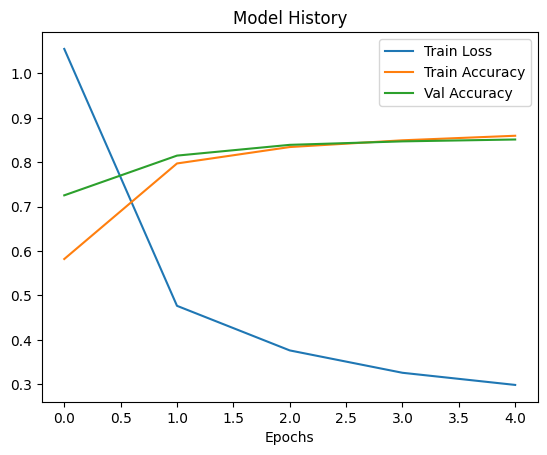

In [156]:
# P1 Plot
plot_history(P1_model_history)

In [132]:
# Ptflops Summary
from ptflops import get_model_complexity_info

with torch.cuda.device(0):
  macs, params = get_model_complexity_info(LeNet_P1, (1, 28, 28), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

LeNet_modern(
  61.71 k, 100.000% Params, 435.65 KMac, 100.000% MACs, 
  (conv): Sequential(
    2.57 k, 4.168% Params, 376.51 KMac, 86.426% MACs, 
    (0): Conv2d(156, 0.253% Params, 122.3 KMac, 28.074% MACs, 1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(0, 0.000% Params, 4.7 KMac, 1.080% MACs, )
    (2): MaxPool2d(0, 0.000% Params, 4.7 KMac, 1.080% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(2.42 k, 3.915% Params, 241.6 KMac, 55.458% MACs, 6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(0, 0.000% Params, 1.6 KMac, 0.367% MACs, )
    (5): MaxPool2d(0, 0.000% Params, 1.6 KMac, 0.367% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    59.13 k, 95.832% Params, 59.13 KMac, 13.574% MACs, 
    (0): Flatten(0, 0.000% Params, 0.0 Mac, 0.000% MACs, start_dim=1, end_dim=-1)
    (1): Linear(48.12 k, 77.983% Params, 48.12 KMac, 11.046% MACs, in_features=400, out_feat

## Problem 2
Try to change the size of the LeNet style network to improve its accuracy in addition to max-pooling and ReLU.

1. Adjust the convolution window size.
2. Adjust the number of output channels (width of each layer).
3. Adjust the number of convolution layers.
4. Adjust the number of fully connected layers.
5. Explore the learning rates.

For all training adjustments, restart training from scratch based on FashinMNIST. Compare the training loss, training accuracy, and validation accuracy against each other and the baseline in problem 1. Argue which adjustment presents the better benefit and generalization. Measure and compare theoretical computation complexity (number of operations and parameters size) using ptflops https://pypi.org/project/ptflops/

### 1. Adjust convolution window size

In [119]:
# Changed kernel_size from 5 to 3, padding from 2 to 1
class LeNet_P2_1(nn.Module):
    def __init__(self, input_features: int, num_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_features, 6, kernel_size=3, padding=1), # 28 + (2*1(padding)) - (3(kernelSize)-1) = 28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 28 / 2 = 14
            nn.Conv2d(6, 16, kernel_size=3), # 14 - (3-1) = 12
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 12 / 2 = 6
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16*6*6, 120), nn.Sigmoid(),
            nn.Linear(120, 84), nn.Sigmoid(),
            nn.Linear(84, num_classes)
        )
    def forward(self, x):
        x = self.conv(x)
        x = self.classifier(x)
        return x

In [120]:
P2_1_model = LeNet_P2_1(input_features=1,
                        num_classes=10)

In [153]:
optimizer_cpu=torch.optim.SGD(params=P2_1_model.parameters(),
                            lr=0.1)
accuracy_fn_cpu = MulticlassAccuracy(num_classes=10)
P2_1_model_history = train(model=P2_1_model,
                         train_dataloader=LeNet_trainLoader,
                         val_dataloader=LeNet_valLoader,
                         optim=optimizer_cpu,
                         loss_fn=loss_fn,
                         accuracy_fn=accuracy_fn_cpu,
                         epochs=10,
                         device="cpu")

 10%|████████▎                                                                          | 1/10 [00:14<02:13, 14.82s/it]

Epoch: 1
--------------- Train Loss: 0.2882, Train Accuracy: 0.8596, Val Loss: 0.3052, Val Accuracy: 0.8623


 20%|████████████████▌                                                                  | 2/10 [00:29<01:58, 14.81s/it]

Epoch: 2
--------------- Train Loss: 0.2705, Train Accuracy: 0.8695, Val Loss: 0.3003, Val Accuracy: 0.8632


 30%|████████████████████████▉                                                          | 3/10 [00:45<01:45, 15.09s/it]

Epoch: 3
--------------- Train Loss: 0.2561, Train Accuracy: 0.8740, Val Loss: 0.3281, Val Accuracy: 0.8518


 40%|█████████████████████████████████▏                                                 | 4/10 [01:00<01:30, 15.09s/it]

Epoch: 4
--------------- Train Loss: 0.2478, Train Accuracy: 0.8766, Val Loss: 0.2900, Val Accuracy: 0.8651


 50%|█████████████████████████████████████████▌                                         | 5/10 [01:15<01:15, 15.03s/it]

Epoch: 5
--------------- Train Loss: 0.2348, Train Accuracy: 0.8827, Val Loss: 0.3045, Val Accuracy: 0.8600


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [01:30<01:00, 15.05s/it]

Epoch: 6
--------------- Train Loss: 0.2279, Train Accuracy: 0.8855, Val Loss: 0.2771, Val Accuracy: 0.8696


 70%|██████████████████████████████████████████████████████████                         | 7/10 [01:45<00:45, 15.01s/it]

Epoch: 7
--------------- Train Loss: 0.2174, Train Accuracy: 0.8899, Val Loss: 0.2869, Val Accuracy: 0.8675


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [01:59<00:29, 14.97s/it]

Epoch: 8
--------------- Train Loss: 0.2090, Train Accuracy: 0.8896, Val Loss: 0.2791, Val Accuracy: 0.8702


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [02:14<00:14, 14.95s/it]

Epoch: 9
--------------- Train Loss: 0.2003, Train Accuracy: 0.8934, Val Loss: 0.2897, Val Accuracy: 0.8683


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:29<00:00, 14.97s/it]

Epoch: 10
--------------- Train Loss: 0.1929, Train Accuracy: 0.8981, Val Loss: 0.2815, Val Accuracy: 0.8694


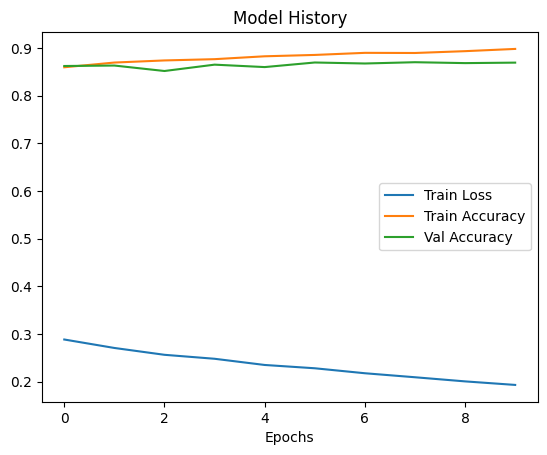

In [157]:
# P2_1 Plot, very similar to P1
plot_history(P2_1_model_history)

In [158]:
with torch.cuda.device(0):
  macs, params = get_model_complexity_info(P2_1_model, (1, 28, 28), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

LeNet_P2_1(
  81.19 k, 100.000% Params, 268.03 KMac, 100.000% MACs, 
  (conv): Sequential(
    940, 1.158% Params, 187.78 KMac, 70.058% MACs, 
    (0): Conv2d(60, 0.074% Params, 47.04 KMac, 17.550% MACs, 1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(0, 0.000% Params, 4.7 KMac, 1.755% MACs, )
    (2): MaxPool2d(0, 0.000% Params, 4.7 KMac, 1.755% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(880, 1.084% Params, 126.72 KMac, 47.278% MACs, 6, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU(0, 0.000% Params, 2.3 KMac, 0.860% MACs, )
    (5): MaxPool2d(0, 0.000% Params, 2.3 KMac, 0.860% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    80.25 k, 98.842% Params, 80.25 KMac, 29.942% MACs, 
    (0): Flatten(0, 0.000% Params, 0.0 Mac, 0.000% MACs, start_dim=1, end_dim=-1)
    (1): Linear(69.24 k, 85.277% Params, 69.24 KMac, 25.833% MACs, in_features=576, out_features=120

### 2. Adjust the number of output channels (width of each layer).

In [123]:
# Increased output channels of each Conv2d by multiplier of 2
class LeNet_P2_2(nn.Module):
    def __init__(self, input_features: int, num_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_features, 16, kernel_size=5, padding=2), # 28 + (2*2(padding)) - (5(kernelSize)-1) = 28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 28 / 2 = 14
            nn.Conv2d(16, 32, kernel_size=5), # 14 - (5-1) = 10
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 10 / 2 = 5
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*5*5, 120), nn.Sigmoid(),
            nn.Linear(120, 84), nn.Sigmoid(),
            nn.Linear(84, num_classes)
        )
    def forward(self, x):
        x = self.conv(x)
        x = self.classifier(x)
        return x

In [152]:
P2_2_model = LeNet_P2_2(input_features=1,
                        num_classes=10)
optimizer_cpu=torch.optim.SGD(params=P2_2_model.parameters(),
                            lr=0.1)
accuracy_fn_cpu = MulticlassAccuracy(num_classes=10)
P2_2_model_history = train(model=P2_2_model,
                         train_dataloader=LeNet_trainLoader,
                         val_dataloader=LeNet_valLoader,
                         optim=optimizer_cpu,
                         loss_fn=loss_fn,
                         accuracy_fn=accuracy_fn_cpu,
                         epochs=10,
                         device="cpu")

 10%|████████▎                                                                          | 1/10 [00:20<03:02, 20.30s/it]

Epoch: 1
--------------- Train Loss: 1.0413, Train Accuracy: 0.5907, Val Loss: 0.5221, Val Accuracy: 0.7709


 20%|████████████████▌                                                                  | 2/10 [00:40<02:43, 20.48s/it]

Epoch: 2
--------------- Train Loss: 0.4285, Train Accuracy: 0.8149, Val Loss: 0.3807, Val Accuracy: 0.8345


 30%|████████████████████████▉                                                          | 3/10 [01:01<02:22, 20.39s/it]

Epoch: 3
--------------- Train Loss: 0.3377, Train Accuracy: 0.8460, Val Loss: 0.3349, Val Accuracy: 0.8523


 40%|█████████████████████████████████▏                                                 | 4/10 [01:22<02:03, 20.60s/it]

Epoch: 4
--------------- Train Loss: 0.2949, Train Accuracy: 0.8595, Val Loss: 0.3072, Val Accuracy: 0.8620


 50%|█████████████████████████████████████████▌                                         | 5/10 [01:42<01:41, 20.35s/it]

Epoch: 5
--------------- Train Loss: 0.2681, Train Accuracy: 0.8691, Val Loss: 0.2924, Val Accuracy: 0.8684


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [02:01<01:20, 20.14s/it]

Epoch: 6
--------------- Train Loss: 0.2448, Train Accuracy: 0.8795, Val Loss: 0.2911, Val Accuracy: 0.8615


 70%|██████████████████████████████████████████████████████████                         | 7/10 [02:22<01:01, 20.33s/it]

Epoch: 7
--------------- Train Loss: 0.2282, Train Accuracy: 0.8852, Val Loss: 0.2969, Val Accuracy: 0.8705


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [02:42<00:40, 20.18s/it]

Epoch: 8
--------------- Train Loss: 0.2121, Train Accuracy: 0.8889, Val Loss: 0.2668, Val Accuracy: 0.8720


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [03:01<00:19, 19.82s/it]

Epoch: 9
--------------- Train Loss: 0.1989, Train Accuracy: 0.8959, Val Loss: 0.2782, Val Accuracy: 0.8657


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:20<00:00, 20.04s/it]

Epoch: 10
--------------- Train Loss: 0.1866, Train Accuracy: 0.9013, Val Loss: 0.2569, Val Accuracy: 0.8761


LeNet_P2_2(
  120.38 k, 100.000% Params, 1.75 MMac, 100.000% MACs, 
  (conv): Sequential(
    13.25 k, 11.005% Params, 1.64 MMac, 93.871% MACs, 
    (0): Conv2d(416, 0.346% Params, 326.14 KMac, 18.658% MACs, 1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(0, 0.000% Params, 12.54 KMac, 0.718% MACs, )
    (2): MaxPool2d(0, 0.000% Params, 12.54 KMac, 0.718% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(12.83 k, 10.659% Params, 1.28 MMac, 73.411% MACs, 16, 32, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(0, 0.000% Params, 3.2 KMac, 0.183% MACs, )
    (5): MaxPool2d(0, 0.000% Params, 3.2 KMac, 0.183% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    107.13 k, 88.995% Params, 107.13 KMac, 6.129% MACs, 
    (0): Flatten(0, 0.000% Params, 0.0 Mac, 0.000% MACs, start_dim=1, end_dim=-1)
    (1): Linear(96.12 k, 79.846% Params, 96.12 KMac, 5.499% MACs, in_features=800, out

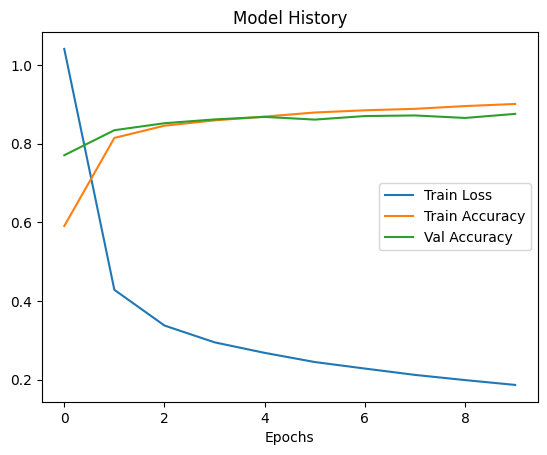

In [159]:
# P2_2 Plot, performed slightly worse with overfitting at the end
plot_history(P2_2_model_history)

with torch.cuda.device(0):
  macs, params = get_model_complexity_info(P2_2_model, (1, 28, 28), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

### 3. Adjust the number of convolution layers.

In [130]:
# Added another "block" of conv2d, relu, and Maxpool.
# Also adjusted original conv2d layers to have padding=2
class LeNet_P2_3(nn.Module):
    def __init__(self, input_features: int, num_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_features, 6, kernel_size=5, padding=2), # 28 + (2*2(padding)) - (5(kernelSize)-1) = 28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 28 / 2 = 14
            nn.Conv2d(6, 16, kernel_size=5, padding=2), # 14
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 14 / 2 = 7
            nn.Conv2d(16, 32, kernel_size=2), # 7 - (2-1) = 6
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 6 / 2 = 3
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*3*3, 120), nn.Sigmoid(),
            nn.Linear(120, 84), nn.Sigmoid(),
            nn.Linear(84, num_classes)
        )
    def forward(self, x):
        x = self.conv(x)
        x = self.classifier(x)
        return x

In [151]:
P2_3_model = LeNet_P2_3(input_features=1,
                        num_classes=10)
optimizer_cpu=torch.optim.SGD(params=P2_3_model.parameters(),
                            lr=0.1)
accuracy_fn_cpu = MulticlassAccuracy(num_classes=10)
P2_3_model_history = train(model=P2_3_model,
                         train_dataloader=LeNet_trainLoader,
                         val_dataloader=LeNet_valLoader,
                         optim=optimizer_cpu,
                         loss_fn=loss_fn,
                         accuracy_fn=accuracy_fn_cpu,
                         epochs=10,
                         device="cpu")

 10%|████████▎                                                                          | 1/10 [00:17<02:33, 17.05s/it]

Epoch: 1
--------------- Train Loss: 1.3923, Train Accuracy: 0.4526, Val Loss: 0.6881, Val Accuracy: 0.6990


 20%|████████████████▌                                                                  | 2/10 [00:34<02:19, 17.41s/it]

Epoch: 2
--------------- Train Loss: 0.5629, Train Accuracy: 0.7549, Val Loss: 0.4766, Val Accuracy: 0.7955


 30%|████████████████████████▉                                                          | 3/10 [00:51<02:01, 17.29s/it]

Epoch: 3
--------------- Train Loss: 0.4236, Train Accuracy: 0.8159, Val Loss: 0.3938, Val Accuracy: 0.8279


 40%|█████████████████████████████████▏                                                 | 4/10 [01:09<01:43, 17.30s/it]

Epoch: 4
--------------- Train Loss: 0.3573, Train Accuracy: 0.8360, Val Loss: 0.3591, Val Accuracy: 0.8388


 50%|█████████████████████████████████████████▌                                         | 5/10 [01:26<01:26, 17.23s/it]

Epoch: 5
--------------- Train Loss: 0.3206, Train Accuracy: 0.8493, Val Loss: 0.3449, Val Accuracy: 0.8460


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [01:43<01:09, 17.30s/it]

Epoch: 6
--------------- Train Loss: 0.2965, Train Accuracy: 0.8608, Val Loss: 0.3603, Val Accuracy: 0.8401


 70%|██████████████████████████████████████████████████████████                         | 7/10 [02:01<00:52, 17.48s/it]

Epoch: 7
--------------- Train Loss: 0.2807, Train Accuracy: 0.8670, Val Loss: 0.3171, Val Accuracy: 0.8572


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [02:19<00:35, 17.57s/it]

Epoch: 8
--------------- Train Loss: 0.2681, Train Accuracy: 0.8700, Val Loss: 0.2961, Val Accuracy: 0.8599


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [02:36<00:17, 17.44s/it]

Epoch: 9
--------------- Train Loss: 0.2573, Train Accuracy: 0.8721, Val Loss: 0.3059, Val Accuracy: 0.8567


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:54<00:00, 17.41s/it]

Epoch: 10
--------------- Train Loss: 0.2485, Train Accuracy: 0.8769, Val Loss: 0.2969, Val Accuracy: 0.8648


LeNet_P2_3(
  50.35 k, 100.000% Params, 734.4 KMac, 100.000% MACs, 
  (conv): Sequential(
    4.65 k, 9.240% Params, 688.7 KMac, 93.778% MACs, 
    (0): Conv2d(156, 0.310% Params, 122.3 KMac, 16.654% MACs, 1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(0, 0.000% Params, 4.7 KMac, 0.641% MACs, )
    (2): MaxPool2d(0, 0.000% Params, 4.7 KMac, 0.641% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(2.42 k, 4.799% Params, 473.54 KMac, 64.479% MACs, 6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(0, 0.000% Params, 3.14 KMac, 0.427% MACs, )
    (5): MaxPool2d(0, 0.000% Params, 3.14 KMac, 0.427% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(2.08 k, 4.131% Params, 74.88 KMac, 10.196% MACs, 16, 32, kernel_size=(2, 2), stride=(1, 1))
    (7): ReLU(0, 0.000% Params, 1.15 KMac, 0.157% MACs, )
    (8): MaxPool2d(0, 0.000% Params, 1.15 KMac, 0.157% MACs, kernel_size=2, strid

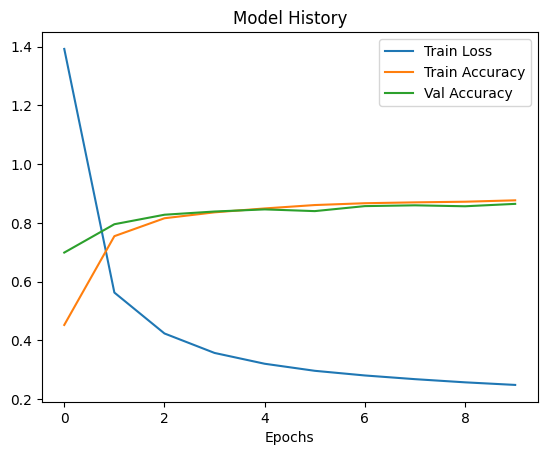

In [160]:
# P2_3 performed about the same as base
with torch.cuda.device(0):
  macs, params = get_model_complexity_info(P2_3_model, (1, 28, 28), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))
plot_history(P2_3_model_history)

### 4. Adjust the number of fully connected layers.

In [142]:
# Add another Linear layer to gradually get to num_classes
# Changed linear layers to have ReLU activation function
class LeNet_P2_4(nn.Module):
    def __init__(self, input_features: int, num_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_features, 6, kernel_size=5, padding=2), # 28 + (2*2(padding)) - (5(kernelSize)-1) = 28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 28 / 2 = 14
            nn.Conv2d(6, 16, kernel_size=5), # 14 - (5-1) = 10
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 10 / 2 = 5
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16*5*5, 120), nn.ReLU(),
            nn.Linear(120, 84), nn.ReLU(),
            nn.Linear(84, int(84/2)), nn.ReLU(),
            nn.Linear(int(84/2), num_classes)
        )
    def forward(self, x):
        x = self.conv(x)
        x = self.classifier(x)
        return x

In [150]:
P2_4_model = LeNet_P2_4(input_features=1,
                        num_classes=10).to("cuda")
optimizer_gpu=torch.optim.SGD(params=P2_4_model.parameters(),
                            lr=0.1)
accuracy_fn_gpu = MulticlassAccuracy(num_classes=10).to("cuda")
P2_4_model_history = train(model=P2_4_model,
                         train_dataloader=LeNet_trainLoader,
                         val_dataloader=LeNet_valLoader,
                         optim=optimizer_gpu,
                         loss_fn=loss_fn,
                         accuracy_fn=accuracy_fn_gpu,
                         epochs=10,
                         device="cuda")

 10%|████████▎                                                                          | 1/10 [00:19<02:51, 19.05s/it]

Epoch: 1
--------------- Train Loss: 0.6583, Train Accuracy: 0.7233, Val Loss: 0.4145, Val Accuracy: 0.8177


 20%|████████████████▌                                                                  | 2/10 [00:38<02:34, 19.28s/it]

Epoch: 2
--------------- Train Loss: 0.3564, Train Accuracy: 0.8379, Val Loss: 0.3462, Val Accuracy: 0.8438


 30%|████████████████████████▉                                                          | 3/10 [00:58<02:15, 19.40s/it]

Epoch: 3
--------------- Train Loss: 0.3106, Train Accuracy: 0.8544, Val Loss: 0.3257, Val Accuracy: 0.8564


 40%|█████████████████████████████████▏                                                 | 4/10 [01:18<01:59, 19.96s/it]

Epoch: 4
--------------- Train Loss: 0.2819, Train Accuracy: 0.8648, Val Loss: 0.3303, Val Accuracy: 0.8487


 50%|█████████████████████████████████████████▌                                         | 5/10 [01:40<01:42, 20.46s/it]

Epoch: 5
--------------- Train Loss: 0.2638, Train Accuracy: 0.8711, Val Loss: 0.3089, Val Accuracy: 0.8549


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [02:01<01:22, 20.71s/it]

Epoch: 6
--------------- Train Loss: 0.2462, Train Accuracy: 0.8782, Val Loss: 0.2962, Val Accuracy: 0.8664


 70%|██████████████████████████████████████████████████████████                         | 7/10 [02:22<01:02, 20.96s/it]

Epoch: 7
--------------- Train Loss: 0.2335, Train Accuracy: 0.8853, Val Loss: 0.2817, Val Accuracy: 0.8701


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [02:43<00:41, 20.95s/it]

Epoch: 8
--------------- Train Loss: 0.2225, Train Accuracy: 0.8855, Val Loss: 0.3188, Val Accuracy: 0.8575


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [03:03<00:20, 20.41s/it]

Epoch: 9
--------------- Train Loss: 0.2109, Train Accuracy: 0.8895, Val Loss: 0.2773, Val Accuracy: 0.8722


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:22<00:00, 20.29s/it]

Epoch: 10
--------------- Train Loss: 0.2019, Train Accuracy: 0.8915, Val Loss: 0.2892, Val Accuracy: 0.8727


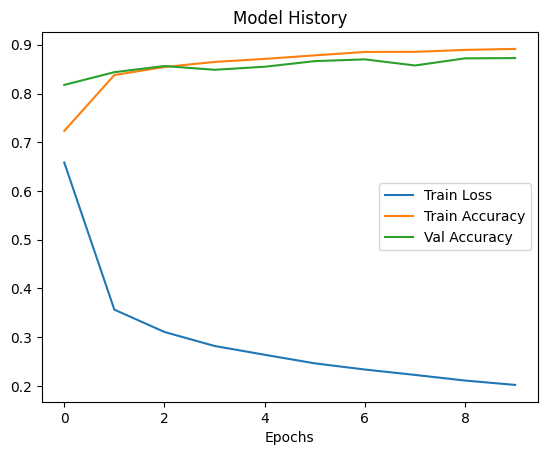

In [161]:
# P2_4 showed better training but began to overfit
plot_history(P2_4_model_history)

In [162]:
with torch.cuda.device(0):
  macs, params = get_model_complexity_info(P2_4_model, (1, 28, 28), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

LeNet_P2_4(
  64.86 k, 100.000% Params, 439.04 KMac, 100.000% MACs, 
  (conv): Sequential(
    2.57 k, 3.966% Params, 376.51 KMac, 85.758% MACs, 
    (0): Conv2d(156, 0.241% Params, 122.3 KMac, 27.857% MACs, 1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(0, 0.000% Params, 4.7 KMac, 1.071% MACs, )
    (2): MaxPool2d(0, 0.000% Params, 4.7 KMac, 1.071% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(2.42 k, 3.725% Params, 241.6 KMac, 55.029% MACs, 6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(0, 0.000% Params, 1.6 KMac, 0.364% MACs, )
    (5): MaxPool2d(0, 0.000% Params, 1.6 KMac, 0.364% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    62.28 k, 96.034% Params, 62.53 KMac, 14.242% MACs, 
    (0): Flatten(0, 0.000% Params, 0.0 Mac, 0.000% MACs, start_dim=1, end_dim=-1)
    (1): Linear(48.12 k, 74.195% Params, 48.12 KMac, 10.960% MACs, in_features=400, out_featur

### 5. Explore the learning rates

In [149]:
# LR = 0.01
# Assuming to use LeNet_modern for this part
P2_5_model = LeNet_modern(input_features=1,
                          num_classes=10).to("cuda")
# Decreased learning rate from 0.1 to 0.01
optimizer_gpu=torch.optim.SGD(params=P2_5_model.parameters(),
                            lr=0.01)
# Increasing epochs due to smaller LR
accuracy_fn_gpu = MulticlassAccuracy(num_classes=10).to("cuda")
P2_5_model_history = train(model=P2_5_model,
                         train_dataloader=LeNet_trainLoader,
                         val_dataloader=LeNet_valLoader,
                         optim=optimizer_gpu,
                         loss_fn=loss_fn,
                         accuracy_fn=accuracy_fn_gpu,
                         epochs=20,
                         device="cuda")

  5%|████▏                                                                              | 1/20 [00:21<06:50, 21.59s/it]

Epoch: 1
--------------- Train Loss: 2.3014, Train Accuracy: 0.1077, Val Loss: 2.2941, Val Accuracy: 0.0962


 10%|████████▎                                                                          | 2/20 [00:43<06:31, 21.76s/it]

Epoch: 2
--------------- Train Loss: 2.0975, Train Accuracy: 0.2720, Val Loss: 1.5970, Val Accuracy: 0.4767


 15%|████████████▍                                                                      | 3/20 [01:05<06:13, 21.98s/it]

Epoch: 3
--------------- Train Loss: 1.2425, Train Accuracy: 0.5649, Val Loss: 1.0419, Val Accuracy: 0.6089


 20%|████████████████▌                                                                  | 4/20 [01:26<05:46, 21.67s/it]

Epoch: 4
--------------- Train Loss: 0.9259, Train Accuracy: 0.6518, Val Loss: 0.8459, Val Accuracy: 0.6853


 25%|████████████████████▊                                                              | 5/20 [01:49<05:27, 21.87s/it]

Epoch: 5
--------------- Train Loss: 0.7636, Train Accuracy: 0.7074, Val Loss: 0.7193, Val Accuracy: 0.7171


 30%|████████████████████████▉                                                          | 6/20 [02:10<05:02, 21.57s/it]

Epoch: 6
--------------- Train Loss: 0.6618, Train Accuracy: 0.7333, Val Loss: 0.6478, Val Accuracy: 0.7392


 35%|█████████████████████████████                                                      | 7/20 [02:31<04:40, 21.54s/it]

Epoch: 7
--------------- Train Loss: 0.5944, Train Accuracy: 0.7523, Val Loss: 0.5914, Val Accuracy: 0.7531


 40%|█████████████████████████████████▏                                                 | 8/20 [02:53<04:21, 21.81s/it]

Epoch: 8
--------------- Train Loss: 0.5476, Train Accuracy: 0.7656, Val Loss: 0.5523, Val Accuracy: 0.7606


 45%|█████████████████████████████████████▎                                             | 9/20 [03:15<03:58, 21.72s/it]

Epoch: 9
--------------- Train Loss: 0.5140, Train Accuracy: 0.7795, Val Loss: 0.5209, Val Accuracy: 0.7748


 50%|█████████████████████████████████████████                                         | 10/20 [03:36<03:34, 21.50s/it]

Epoch: 10
--------------- Train Loss: 0.4871, Train Accuracy: 0.7938, Val Loss: 0.5007, Val Accuracy: 0.7945


 55%|█████████████████████████████████████████████                                     | 11/20 [03:58<03:13, 21.54s/it]

Epoch: 11
--------------- Train Loss: 0.4639, Train Accuracy: 0.8052, Val Loss: 0.4884, Val Accuracy: 0.7924


 60%|█████████████████████████████████████████████████▏                                | 12/20 [04:19<02:50, 21.33s/it]

Epoch: 12
--------------- Train Loss: 0.4445, Train Accuracy: 0.8134, Val Loss: 0.4639, Val Accuracy: 0.8095


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [04:40<02:28, 21.26s/it]

Epoch: 13
--------------- Train Loss: 0.4291, Train Accuracy: 0.8170, Val Loss: 0.4464, Val Accuracy: 0.8158


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [05:01<02:08, 21.37s/it]

Epoch: 14
--------------- Train Loss: 0.4138, Train Accuracy: 0.8218, Val Loss: 0.4296, Val Accuracy: 0.8236


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [05:22<01:45, 21.18s/it]

Epoch: 15
--------------- Train Loss: 0.4007, Train Accuracy: 0.8276, Val Loss: 0.4159, Val Accuracy: 0.8222


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [05:44<01:25, 21.34s/it]

Epoch: 16
--------------- Train Loss: 0.3877, Train Accuracy: 0.8334, Val Loss: 0.4013, Val Accuracy: 0.8275


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [06:05<01:04, 21.36s/it]

Epoch: 17
--------------- Train Loss: 0.3756, Train Accuracy: 0.8378, Val Loss: 0.4089, Val Accuracy: 0.8250


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [06:26<00:42, 21.36s/it]

Epoch: 18
--------------- Train Loss: 0.3641, Train Accuracy: 0.8414, Val Loss: 0.3890, Val Accuracy: 0.8352


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [06:47<00:21, 21.23s/it]

Epoch: 19
--------------- Train Loss: 0.3541, Train Accuracy: 0.8422, Val Loss: 0.3738, Val Accuracy: 0.8363


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [07:06<00:00, 21.35s/it]

Epoch: 20
--------------- Train Loss: 0.3452, Train Accuracy: 0.8489, Val Loss: 0.3716, Val Accuracy: 0.8392


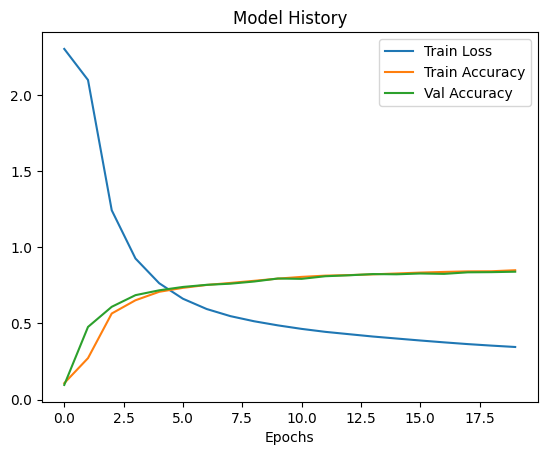

In [164]:
plot_history(P2_5_model_history)

In [165]:
# LR = 0.2
P2_5b_model = LeNet_modern(input_features=1,
                          num_classes=10).to("cuda")
# Increased learning rate from 0.1 to 0.2
optimizer_gpu=torch.optim.SGD(params=P2_5b_model.parameters(),
                            lr=0.2)
accuracy_fn_gpu = MulticlassAccuracy(num_classes=10).to("cuda")
P2_5b_model_history = train(model=P2_5b_model,
                         train_dataloader=LeNet_trainLoader,
                         val_dataloader=LeNet_valLoader,
                         optim=optimizer_gpu,
                         loss_fn=loss_fn,
                         accuracy_fn=accuracy_fn_gpu,
                         epochs=10,
                         device="cuda")

 10%|████████▎                                                                          | 1/10 [00:21<03:16, 21.82s/it]

Epoch: 1
--------------- Train Loss: 0.8327, Train Accuracy: 0.6600, Val Loss: 0.4520, Val Accuracy: 0.8061


 20%|████████████████▌                                                                  | 2/10 [00:41<02:45, 20.69s/it]

Epoch: 2
--------------- Train Loss: 0.3974, Train Accuracy: 0.8249, Val Loss: 0.3847, Val Accuracy: 0.8269


 30%|████████████████████████▉                                                          | 3/10 [01:01<02:20, 20.07s/it]

Epoch: 3
--------------- Train Loss: 0.3380, Train Accuracy: 0.8442, Val Loss: 0.3484, Val Accuracy: 0.8414


 40%|█████████████████████████████████▏                                                 | 4/10 [01:20<01:59, 19.98s/it]

Epoch: 4
--------------- Train Loss: 0.3096, Train Accuracy: 0.8543, Val Loss: 0.3467, Val Accuracy: 0.8433


 50%|█████████████████████████████████████████▌                                         | 5/10 [01:41<01:40, 20.10s/it]

Epoch: 5
--------------- Train Loss: 0.2905, Train Accuracy: 0.8573, Val Loss: 0.3153, Val Accuracy: 0.8565


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [02:01<01:21, 20.31s/it]

Epoch: 6
--------------- Train Loss: 0.2739, Train Accuracy: 0.8663, Val Loss: 0.3046, Val Accuracy: 0.8579


 70%|██████████████████████████████████████████████████████████                         | 7/10 [02:22<01:00, 20.27s/it]

Epoch: 7
--------------- Train Loss: 0.2643, Train Accuracy: 0.8730, Val Loss: 0.2931, Val Accuracy: 0.8638


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [02:43<00:41, 20.58s/it]

Epoch: 8
--------------- Train Loss: 0.2581, Train Accuracy: 0.8721, Val Loss: 0.2934, Val Accuracy: 0.8658


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [03:02<00:20, 20.17s/it]

Epoch: 9
--------------- Train Loss: 0.2535, Train Accuracy: 0.8737, Val Loss: 0.2942, Val Accuracy: 0.8659


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:23<00:00, 20.36s/it]

Epoch: 10
--------------- Train Loss: 0.2478, Train Accuracy: 0.8749, Val Loss: 0.3070, Val Accuracy: 0.8603


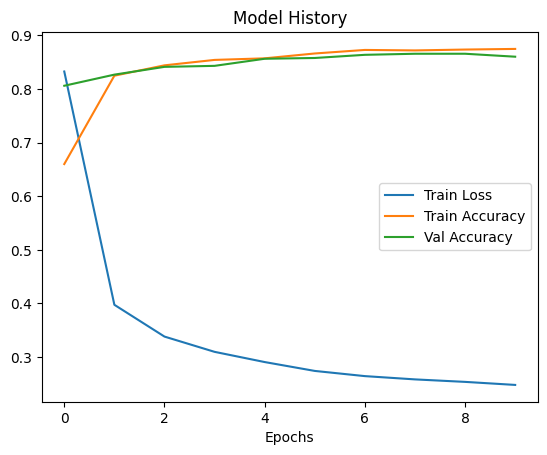

In [166]:
plot_history(P2_5b_model_history)

In [167]:
with torch.cuda.device(0):
  macs, params = get_model_complexity_info(P2_5b_model, (1, 28, 28), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

LeNet_modern(
  61.71 k, 100.000% Params, 435.65 KMac, 100.000% MACs, 
  (conv): Sequential(
    2.57 k, 4.168% Params, 376.51 KMac, 86.426% MACs, 
    (0): Conv2d(156, 0.253% Params, 122.3 KMac, 28.074% MACs, 1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(0, 0.000% Params, 4.7 KMac, 1.080% MACs, )
    (2): MaxPool2d(0, 0.000% Params, 4.7 KMac, 1.080% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(2.42 k, 3.915% Params, 241.6 KMac, 55.458% MACs, 6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(0, 0.000% Params, 1.6 KMac, 0.367% MACs, )
    (5): MaxPool2d(0, 0.000% Params, 1.6 KMac, 0.367% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    59.13 k, 95.832% Params, 59.13 KMac, 13.574% MACs, 
    (0): Flatten(0, 0.000% Params, 0.0 Mac, 0.000% MACs, start_dim=1, end_dim=-1)
    (1): Linear(48.12 k, 77.983% Params, 48.12 KMac, 11.046% MACs, in_features=400, out_feat

## Problem 3: Apply dropout on best performing model

In [171]:
# P2_4 model performed the best, so dropout will be added
class LeNet_P3(nn.Module):
    def __init__(self, input_features: int, num_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_features, 6, kernel_size=5, padding=2), # 28 + (2*2(padding)) - (5(kernelSize)-1) = 28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 28 / 2 = 14
            nn.Dropout2d(0.4),
            nn.Conv2d(6, 16, kernel_size=5), # 14 - (5-1) = 10
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 10 / 2 = 5
            nn.Dropout2d(0.4)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16*5*5, 120), nn.Dropout(0.3), nn.ReLU(),
            nn.Linear(120, 84), nn.Dropout(0.3), nn.ReLU(),
            nn.Linear(84, int(84/2)), nn.Dropout(0.3), nn.ReLU(),
            nn.Linear(int(84/2), num_classes)
        )
    def forward(self, x):
        x = self.conv(x)
        x = self.classifier(x)
        return x

In [173]:
P3_model = LeNet_P3(input_features=1,
                    num_classes=10).to("cuda")
optimizer_gpu=torch.optim.SGD(params=P3_model.parameters(),
                            lr=0.1)
accuracy_fn_gpu = MulticlassAccuracy(num_classes=10).to("cuda")
P3_model_history = train(model=P3_model,
                         train_dataloader=LeNet_trainLoader,
                         val_dataloader=LeNet_valLoader,
                         optim=optimizer_gpu,
                         loss_fn=loss_fn,
                         accuracy_fn=accuracy_fn_gpu,
                         epochs=10,
                         device="cuda")

 10%|████████▎                                                                          | 1/10 [00:21<03:13, 21.54s/it]

Epoch: 1
--------------- Train Loss: 1.0198, Train Accuracy: 0.5966, Val Loss: 0.5656, Val Accuracy: 0.7506


 20%|████████████████▌                                                                  | 2/10 [00:43<02:52, 21.52s/it]

Epoch: 2
--------------- Train Loss: 0.6889, Train Accuracy: 0.7273, Val Loss: 0.5044, Val Accuracy: 0.7710


 30%|████████████████████████▉                                                          | 3/10 [01:05<02:32, 21.78s/it]

Epoch: 3
--------------- Train Loss: 0.6204, Train Accuracy: 0.7553, Val Loss: 0.4459, Val Accuracy: 0.8073


 40%|█████████████████████████████████▏                                                 | 4/10 [01:26<02:09, 21.59s/it]

Epoch: 4
--------------- Train Loss: 0.5839, Train Accuracy: 0.7690, Val Loss: 0.4235, Val Accuracy: 0.8186


 50%|█████████████████████████████████████████▌                                         | 5/10 [01:49<01:49, 21.97s/it]

Epoch: 5
--------------- Train Loss: 0.5663, Train Accuracy: 0.7750, Val Loss: 0.4090, Val Accuracy: 0.8210


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [02:11<01:27, 21.96s/it]

Epoch: 6
--------------- Train Loss: 0.5438, Train Accuracy: 0.7823, Val Loss: 0.4074, Val Accuracy: 0.8183


 70%|██████████████████████████████████████████████████████████                         | 7/10 [02:33<01:05, 21.99s/it]

Epoch: 7
--------------- Train Loss: 0.5440, Train Accuracy: 0.7831, Val Loss: 0.3969, Val Accuracy: 0.8256


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [02:54<00:43, 21.97s/it]

Epoch: 8
--------------- Train Loss: 0.5374, Train Accuracy: 0.7855, Val Loss: 0.3965, Val Accuracy: 0.8177


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [03:16<00:21, 21.91s/it]

Epoch: 9
--------------- Train Loss: 0.5306, Train Accuracy: 0.7882, Val Loss: 0.3896, Val Accuracy: 0.8171


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:39<00:00, 21.93s/it]

Epoch: 10
--------------- Train Loss: 0.5297, Train Accuracy: 0.7897, Val Loss: 0.3771, Val Accuracy: 0.8333


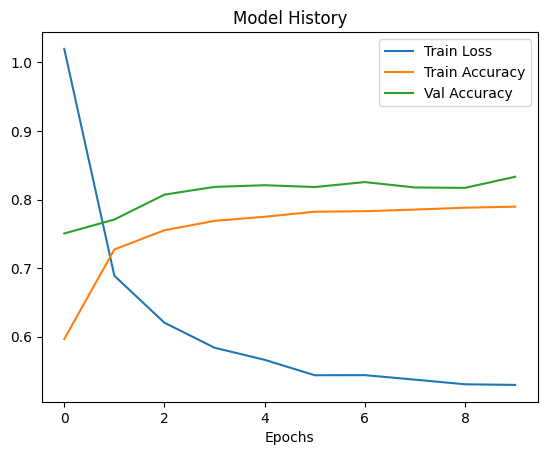

In [174]:
plot_history(P3_model_history)

The dropout version does not perform as well as the best performing model of Problem 2. The generalization gap is steadily decreasing in the dropout version, but the val accuracy is behind by 4% and wouldn't increase with more epochs.

## Problem 4: AlexNet Adaptation for FashionMNIST

In [185]:
class AlexNet_small(nn.Module):
    def __init__(self, input_features: int, num_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_features, 96, kernel_size=9, padding=2), # 28 + (2*2(padding)) - (9(kernelSize)-1) = 24
            nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2), # 24 / 2 = 6
            nn.Conv2d(96, 256, kernel_size=5, padding=2), # 14 + (2*3) - (5-1) = 16
            nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2), # 14 / 2 = 8
            nn.Conv2d(256, 384, kernel_size=2, padding=1), nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=2, padding=1), nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=2, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 8 / 2 = 4
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*4*4, 920), nn.ReLU(), nn.Dropout(p=0.5),
            nn.Linear(920, int(920/2)), nn.ReLU(), nn.Dropout(p=0.5),
            nn.Linear(int(920/2), num_classes)
        )
    def forward(self, x):
        x = self.conv(x)
        x = self.classifier(x)
        return x

In [186]:
P4_model = AlexNet_small(input_features=1,
                    num_classes=10).to("cuda")
optimizer_gpu=torch.optim.SGD(params=P4_model.parameters(),
                            lr=0.1)
accuracy_fn_gpu = MulticlassAccuracy(num_classes=10).to("cuda")
P4_model_history = train(model=P4_model,
                         train_dataloader=LeNet_trainLoader,
                         val_dataloader=LeNet_valLoader,
                         optim=optimizer_gpu,
                         loss_fn=loss_fn,
                         accuracy_fn=accuracy_fn_gpu,
                         epochs=10,
                         device="cuda")

 10%|████████▎                                                                          | 1/10 [00:24<03:37, 24.17s/it]

Epoch: 1
--------------- Train Loss: 0.7683, Train Accuracy: 0.6874, Val Loss: 0.3917, Val Accuracy: 0.8261


 20%|████████████████▌                                                                  | 2/10 [00:48<03:12, 24.05s/it]

Epoch: 2
--------------- Train Loss: 0.3797, Train Accuracy: 0.8317, Val Loss: 0.3291, Val Accuracy: 0.8524


 30%|████████████████████████▉                                                          | 3/10 [01:11<02:46, 23.80s/it]

Epoch: 3
--------------- Train Loss: 0.3101, Train Accuracy: 0.8564, Val Loss: 0.3088, Val Accuracy: 0.8585


 40%|█████████████████████████████████▏                                                 | 4/10 [01:35<02:23, 23.92s/it]

Epoch: 4
--------------- Train Loss: 0.2740, Train Accuracy: 0.8675, Val Loss: 0.2911, Val Accuracy: 0.8634


 50%|█████████████████████████████████████████▌                                         | 5/10 [01:59<01:59, 23.96s/it]

Epoch: 5
--------------- Train Loss: 0.2442, Train Accuracy: 0.8797, Val Loss: 0.3048, Val Accuracy: 0.8603


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [02:23<01:35, 23.98s/it]

Epoch: 6
--------------- Train Loss: 0.2239, Train Accuracy: 0.8865, Val Loss: 0.2905, Val Accuracy: 0.8670


 70%|██████████████████████████████████████████████████████████                         | 7/10 [02:47<01:11, 23.97s/it]

Epoch: 7
--------------- Train Loss: 0.2023, Train Accuracy: 0.8924, Val Loss: 0.2622, Val Accuracy: 0.8784


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [03:11<00:48, 24.02s/it]

Epoch: 8
--------------- Train Loss: 0.1847, Train Accuracy: 0.8993, Val Loss: 0.2540, Val Accuracy: 0.8814


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [03:36<00:24, 24.11s/it]

Epoch: 9
--------------- Train Loss: 0.1723, Train Accuracy: 0.9045, Val Loss: 0.2621, Val Accuracy: 0.8800


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:00<00:00, 24.01s/it]

Epoch: 10
--------------- Train Loss: 0.1597, Train Accuracy: 0.9086, Val Loss: 0.2688, Val Accuracy: 0.8787


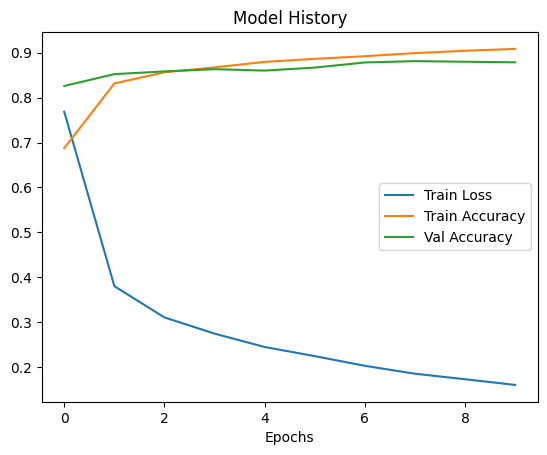

In [187]:
plot_history(P4_model_history)

AlexNet_small performed slightly better than the previous models tested, but at a cost of computational complexity and parameter size. Due to the increased size of the model, it would be better to design a less complex model

In [188]:
with torch.cuda.device(0):
  macs, params = get_model_complexity_info(P4_model, (1, 28, 28), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

AlexNet_small(
  6.2 M, 100.000% Params, 186.44 MMac, 100.000% MACs, 
  (conv): Sequential(
    2.0 M, 32.269% Params, 182.24 MMac, 97.748% MACs, 
    (0): Conv2d(7.87 k, 0.127% Params, 4.53 MMac, 2.432% MACs, 1, 96, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2))
    (1): ReLU(0, 0.000% Params, 55.3 KMac, 0.030% MACs, )
    (2): MaxPool2d(0, 0.000% Params, 55.3 KMac, 0.030% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(614.66 k, 9.918% Params, 88.51 MMac, 47.473% MACs, 96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(0, 0.000% Params, 36.86 KMac, 0.020% MACs, )
    (5): MaxPool2d(0, 0.000% Params, 36.86 KMac, 0.020% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(393.6 k, 6.351% Params, 19.29 MMac, 10.344% MACs, 256, 384, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (7): ReLU(0, 0.000% Params, 18.82 KMac, 0.010% MACs, )
    (8): Conv2d(590.21 k, 9.524% Params, 37.77 MM

## Problem 5: Design better model for 28x28 image training, beating revised AlexNet accuracy while keeping lower theoretical complexity

In [220]:
# Smaller version of VGG
class VGG_s(nn.Module):
    def __init__(self, input_features: int,
                 hidden_outputs: int,
                 num_classes: int):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(input_features, hidden_outputs, # 28
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_outputs, hidden_outputs, kernel_size=3, padding=1), # 28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 28/2 = 14
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(hidden_outputs, hidden_outputs*2, kernel_size=3, padding=1), # 14
            nn.ReLU(),
            nn.Conv2d(hidden_outputs*2, hidden_outputs*2, kernel_size=3, padding=1), # 14
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # 14/2 = 7
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear((hidden_outputs*2)*7*7, int((hidden_outputs*2*7*7)/2)), nn.ReLU(),
            nn.Linear(int((hidden_outputs*2*7*7)/2), int(((hidden_outputs*2*7*7)/2)/2)), nn.ReLU(),
            nn.Linear(int(((hidden_outputs*2*7*7)/2)/2), num_classes),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.classifier(x)
        return x

In [223]:
P5_model = VGG_s(input_features=1,
                 hidden_outputs=14,
                 num_classes=10).to("cuda")
with torch.cuda.device(0):
  macs, params = get_model_complexity_info(P5_model, (1, 28, 28), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

VGG_s(
  1.19 M, 100.000% Params, 4.82 MMac, 100.000% MACs, 
  (conv_block1): Sequential(
    1.92 k, 0.161% Params, 1.54 MMac, 31.877% MACs, 
    (0): Conv2d(140, 0.012% Params, 109.76 KMac, 2.277% MACs, 1, 14, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(0, 0.000% Params, 10.98 KMac, 0.228% MACs, )
    (2): Conv2d(1.78 k, 0.149% Params, 1.39 MMac, 28.917% MACs, 14, 14, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(0, 0.000% Params, 10.98 KMac, 0.228% MACs, )
    (4): MaxPool2d(0, 0.000% Params, 10.98 KMac, 0.228% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    10.64 k, 0.891% Params, 2.1 MMac, 43.603% MACs, 
    (0): Conv2d(3.56 k, 0.298% Params, 696.98 KMac, 14.458% MACs, 14, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(0, 0.000% Params, 5.49 KMac, 0.114% MACs, )
    (2): Conv2d(7.08 k, 0.594% Params, 1.39 MMac, 28.803% MACs, 28, 28, kernel_size=(3, 3), stride=(

In [224]:
optimizer_gpu=torch.optim.SGD(params=P5_model.parameters(),
                            lr=0.1)
accuracy_fn_gpu = MulticlassAccuracy(num_classes=10).to("cuda")
P5_model_history = train(model=P5_model,
                         train_dataloader=LeNet_trainLoader,
                         val_dataloader=LeNet_valLoader,
                         optim=optimizer_gpu,
                         loss_fn=loss_fn,
                         accuracy_fn=accuracy_fn_gpu,
                         epochs=10,
                         device="cuda")

 10%|████████▎                                                                          | 1/10 [00:19<02:57, 19.75s/it]

Epoch: 1
--------------- Train Loss: 1.9334, Train Accuracy: 0.5257, Val Loss: 1.7225, Val Accuracy: 0.7179


 20%|████████████████▌                                                                  | 2/10 [00:40<02:42, 20.35s/it]

Epoch: 2
--------------- Train Loss: 1.7034, Train Accuracy: 0.7330, Val Loss: 1.6856, Val Accuracy: 0.7496


 30%|████████████████████████▉                                                          | 3/10 [01:00<02:21, 20.24s/it]

Epoch: 3
--------------- Train Loss: 1.6712, Train Accuracy: 0.7636, Val Loss: 1.6664, Val Accuracy: 0.7688


 40%|█████████████████████████████████▏                                                 | 4/10 [01:21<02:02, 20.34s/it]

Epoch: 4
--------------- Train Loss: 1.6550, Train Accuracy: 0.7778, Val Loss: 1.6403, Val Accuracy: 0.7934


 50%|█████████████████████████████████████████▌                                         | 5/10 [01:41<01:41, 20.33s/it]

Epoch: 5
--------------- Train Loss: 1.5950, Train Accuracy: 0.8362, Val Loss: 1.6018, Val Accuracy: 0.8306


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [02:01<01:20, 20.25s/it]

Epoch: 6
--------------- Train Loss: 1.5808, Train Accuracy: 0.8484, Val Loss: 1.5773, Val Accuracy: 0.8559


 70%|██████████████████████████████████████████████████████████                         | 7/10 [02:21<01:00, 20.31s/it]

Epoch: 7
--------------- Train Loss: 1.5748, Train Accuracy: 0.8543, Val Loss: 1.6005, Val Accuracy: 0.8324


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [02:42<00:40, 20.26s/it]

Epoch: 8
--------------- Train Loss: 1.5696, Train Accuracy: 0.8613, Val Loss: 1.5689, Val Accuracy: 0.8622


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [03:02<00:20, 20.45s/it]

Epoch: 9
--------------- Train Loss: 1.5657, Train Accuracy: 0.8643, Val Loss: 1.5779, Val Accuracy: 0.8548


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:23<00:00, 20.39s/it]

Epoch: 10
--------------- Train Loss: 1.5672, Train Accuracy: 0.8650, Val Loss: 1.5758, Val Accuracy: 0.8562


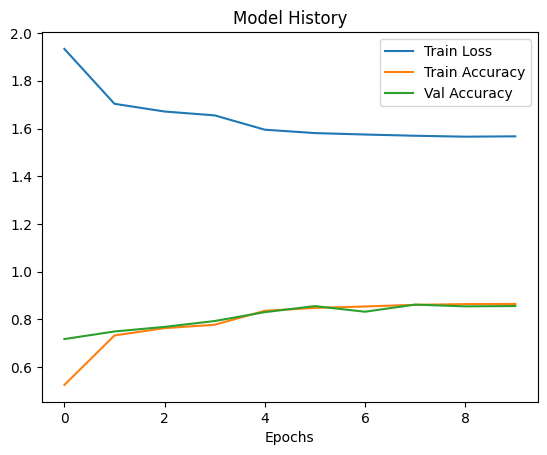

In [226]:
plot_history(P5_model_history)